In [50]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4, ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from torch import nn
from source.miscellaneous.evaluation import evaluate_model, read_model_evaluation_metrics
from einops.einops import rearrange
from source.miscellaneous.model_saving import save_model
from source.datasets.brain_dataset import collate_fn
from torch.optim.lr_scheduler import StepLR

In [43]:
crop_size = 480
affine_transformation_range = 0.1
perspective_transformation_range = 0
patch_size = 16
max_translation_shift = 100
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "../../data/cyto_downscaled_3344_3904_downscaled_4x/"
use_train_data = True
attention = "linear"

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    affine_transformation_range=affine_transformation_range,
    perspective_transformation_range=perspective_transformation_range,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
    load_in_gpu=True
)

In [45]:
batch_size = 1

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn,
)

In [52]:
sum(p.numel() for p in backbone.parameters() if p.requires_grad)

3033248

In [5]:
learning_rate = 0.001
weight_decay = 0.0015
use_coarse_context = False
use_l2_with_standard_deviation = False
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
# block_dimensions_8_2 = [96, 128, 192]
# block_dimensions_16_4 = [64, 96, 128, 192]
block_dimensions = [96, 128, 192]
fine_feature_size = block_dimensions[0]  # 1 for 16_4, 0 for 8_2
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_8_2(block_dimensions=block_dimensions).to(device=device)
# backbone = nn.DataParallel(backbone)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
    attention_type=attention
).to(device=device)
# coarse_loftr = nn.DataParallel(coarse_loftr)


coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
    attention_type=attention
).to(device=device)
# fine_loftr = nn.DataParallel(coarse_loftr)


fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters()) + list(fine_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

learning_rate_gamma = 0.85
learning_rate_step_size = 80
scheduler = StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_gamma)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [6]:
coarse_loss = "official_focal"
alpha = 0.45
gamma = 2
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [7]:
seen_datapoints = 0

In [8]:
training_run = "coarse_matching"
model_directory = "../../models"

In [46]:
epochs = 500

for epoch in range(1, epochs+1):
    epoch_start_time = time.time()
    
    for step, batch in enumerate(dataloader_train):
        image_1_crop, image_2_crop, match_matrix, relative_coordinates, _ = batch
        print(match_matrix.sum())
        break

    #     seen_datapoints += image_1_crop.shape[0]
        
    #     image_1_crop = image_1_crop.to(device=device)
    #     image_2_crop = image_2_crop.to(device=device)
    #     match_matrix = match_matrix.to(device=device)
    #     relative_coordinates = relative_coordinates.to(device=device)

    #     coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
    #     coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
    #     coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
    #     coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

    #     coarse_image_feature_1 = rearrange(
    #         coarse_image_feature_1, "n c h w -> n (h w) c"
    #     )
    #     coarse_image_feature_2 = rearrange(
    #         coarse_image_feature_2, "n c h w -> n (h w) c"
    #     )

    #     coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
    #         coarse_image_feature_1, coarse_image_feature_2
    #     )

    #     coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

    #     coarse_matches_ground_truth = {
    #         "batch_indices": match_matrix.nonzero()[:, 0],
    #         "row_indices": match_matrix.nonzero()[:, 1],
    #         "column_indices": match_matrix.nonzero()[:, 2],
    #     }

    #     fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
    #         coarse_image_feature_1=coarse_image_feature_1,
    #         coarse_image_feature_2=coarse_image_feature_2,
    #         fine_image_feature_1=fine_image_feature_1,
    #         fine_image_feature_2=fine_image_feature_2,
    #         coarse_matches=coarse_matches_ground_truth,
    #         fine_height_width=fine_height_width,
    #         coarse_height_width=coarse_height_width,
    #     )

    #     fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
    #         fine_image_feature_1_unfold, fine_image_feature_2_unfold
    #     )

    #     predicted_relative_coordinates = fine_matching(
    #         fine_image_feature_1_unfold, fine_image_feature_2_unfold
    #     )

    #     if coarse_loss == "focal":
    #         coarse_loss_value = coarse_focal_loss(
    #             predicted_confidence=coarse_matches["confidence_matrix"],
    #             ground_truth_confidence=match_matrix,
    #             alpha=alpha,
    #             gamma=gamma,
    #         )

    #     elif coarse_loss == "official_focal":
    #         coarse_loss_value = coarse_official_focal_loss(
    #             predicted_confidence=coarse_matches["confidence_matrix"],
    #             ground_truth_confidence=match_matrix,
    #             alpha=alpha,
    #             gamma=gamma,
    #         )

    #     elif coarse_loss == "cross_entropy":
    #         coarse_loss_value = coarse_cross_entropy_loss(
    #             predicted_confidence=coarse_matches["confidence_matrix"],
    #             ground_truth_confidence=match_matrix,
    #         )

    #     if fine_loss == "l2":
    #         fine_loss_value = fine_l2_loss(
    #             coordinates_predicted=predicted_relative_coordinates,
    #             coordinates_ground_truth=relative_coordinates,
    #         )

    #     elif fine_loss == "l2_std":
    #         fine_loss_value = fine_l2_loss_with_standard_deviation(
    #             coordinates_predicted=predicted_relative_coordinates,
    #             coordinates_ground_truth=relative_coordinates,
    #         )

    #     loss = coarse_loss_value + fine_loss_value
    #     loss = loss
    #     loss.backward()
        
    #     optimizer.step()
    #     scheduler.step()
    #     epoch_duration = time.time() - epoch_start_time

    #     optimizer.zero_grad()

    #     coarse_loss_history.append(coarse_loss_value.cpu().item())
    #     fine_loss_history.append(fine_loss_value.cpu().item())
    
    # if epoch % 10 ==0:
    #     print(f"Epoch: {epoch}, Seen Datapoints: {seen_datapoints}, Duration: {epoch_duration:.2f} sec, Coarse Loss: {coarse_loss_value:.4f}, Fine Loss: {fine_loss_value:.4f}")

    # if epoch % 20 == 0:
    #     hyperparameters = {
    #     "learning_rate": learning_rate,
    #     "weight_decay": weight_decay,
    #     "coarse_context": use_coarse_context,
    #     "img_size": "3344_3904",
    #     "ResNet": backbone.__class__.__name__,
    #     "affine_transformation_range": affine_transformation_range,
    #     "perspective_transformation_range": perspective_transformation_range,
    #     "temperature": temperature,
    #     "batch_size": batch_size,
    #     "coarse_loss": coarse_loss,
    #     "fine_loss": fine_loss,
    #     "use_train_data": use_train_data,
    #     "block_dimensions": block_dimensions,
    #     "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
    #     "seen_datapoints": seen_datapoints,
    #     "crop_size": crop_size,
    #     "patch_size": patch_size
    #     }

    #     if coarse_loss == "focal":
    #         hyperparameters["gamma"] = gamma
    #         hyperparameters["alpha"] = alpha

    #     if scheduler:
    #         hyperparameters["scheduler"] = scheduler.__class__.__name__
    #         hyperparameters["learning_rate_gamma"] = learning_rate_gamma
    #         hyperparameters["learning_rate_step_size"] = learning_rate_step_size
        
    #     models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
    #     model_directory = save_model(
    #         models,
    #         hyperparameters=hyperparameters,
    #         coarse_loss_history=coarse_loss_history,
    #         fine_loss_history=fine_loss_history,
    #         base_path=f"../../models/{training_run}"
    #     )

tensor(900)
tensor(1156)
tensor(1320)
tensor(1248)
tensor(1023)
tensor(1140)
tensor(1287)


KeyboardInterrupt: 

In [42]:
coarse_image_feature_1.shape

torch.Size([2, 192, 60, 60])

In [22]:
from source.visualization.image_visualization import plot_images_with_matches_via_match_matrix

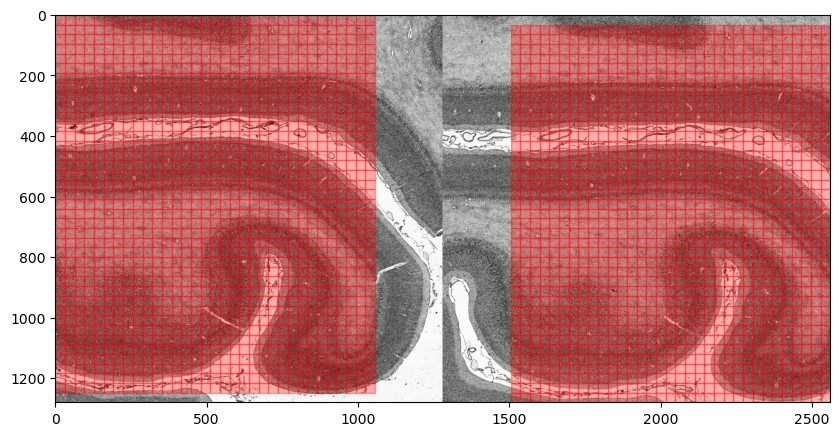

In [49]:
plot_images_with_matches_via_match_matrix(image_1=image_1_crop[0].cpu(), image_2=image_2_crop[0].cpu(), ground_truth_match_matrix=match_matrix[0].cpu(), patch_size=32, visualization_mode="patches")

In [39]:
(480/8)**2, (640/16)**2, (1280/32)**2

(3600.0, 1600.0, 1600.0)